In [72]:
# Segmentation
def segmentation_by_image_processing(img):
    from skimage.filters import difference_of_gaussians, try_all_threshold
    from skimage.morphology import area_opening
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    from skimage.color import label2rgb
    from skimage.measure import label, regionprops
    from scipy import ndimage as ndi
    import numpy as np

    # DoG filter
    dog = difference_of_gaussians(img, low_sigma=2, high_sigma=3)

    # Binarize test（全ての２値化方法）
    # fig, ax = try_all_threshold(dog, figsize=(20, 12), verbose=False)
    # plt.show()

    # Binarize
    bw = dog > np.mean(dog) + np.std(dog)

    # Remove small regions
    large = area_opening(bw, area_threshold=50)

    # Local maxima
    dist = ndi.distance_transform_edt(large)
    # max_coords = peak_local_max(dist, footprint=np.ones((3, 3)))
    max_coords = peak_local_max(dist, min_distance=5, exclude_border=0)
    local_maxima = np.zeros_like(dist, dtype=bool)
    local_maxima[tuple(max_coords.T)] = True

    # Watershed
    markers = ndi.label(local_maxima)[0]
    wat = watershed(-dist, markers, mask=large, watershed_line=True)

    # 元画像にOverlap
    if img.ndim==2:
        color_labels = label2rgb(wat, img, alpha=0.4, bg_label=0)
    else:
        color_labels = np.zeros(img.shape + (3,)) # カラー画像なので、最後に３次元追加。tupleの連結。
        for z in range(0, img.shape[0]):
            color_labels[z,:,:] = label2rgb(wat[z,:,:], img[z,:,:], alpha=0.4, bg_label=0)

    # propsでラベル
    lab = label(wat)
    props = regionprops(lab)
    lab = np.float32(lab)
    for i, prop in enumerate(props):
        try:
            lab[lab==i+1] = prop.solidity # 注意：i+1にする
        except:
            lab[lab==i+1] = 1 # solidityの場合、１つのZ面でしか検出されていないと計算できない

    return dog, bw, large, dist, wat, color_labels, lab

    # test chan_vese
    # from skimage.segmentation import chan_vese
    # from skimage.morphology import dilation, diamond
    # bw_large = dilation(bw, diamond(3))
    # bw_large_f = np.float16(bw_large)
    # test = chan_vese(img, mu=0.1, lambda1=1, lambda2=1, tol=1e-5,
    #                dt=0.5, init_level_set=bw_large_f)

    # test active_contour
    # from skimage.segmentation import active_contour
    # from skimage.morphology import dilation, diamond
    # from skimage.measure import label, regionprops, find_contours

    # bw_large = dilation(bw, diamond(3))
    # props = regionprops(np.uint8(bw_large))
    # test1 = active_contour(img, props[0].coords, w_edge=0, w_line=1) 

    # contours = find_contours(bw_large, 0.5)
    # contours = np.uint8(np.concatenate(contours))
    # test2 = active_contour(img, contours, w_edge=0, w_line=1) 


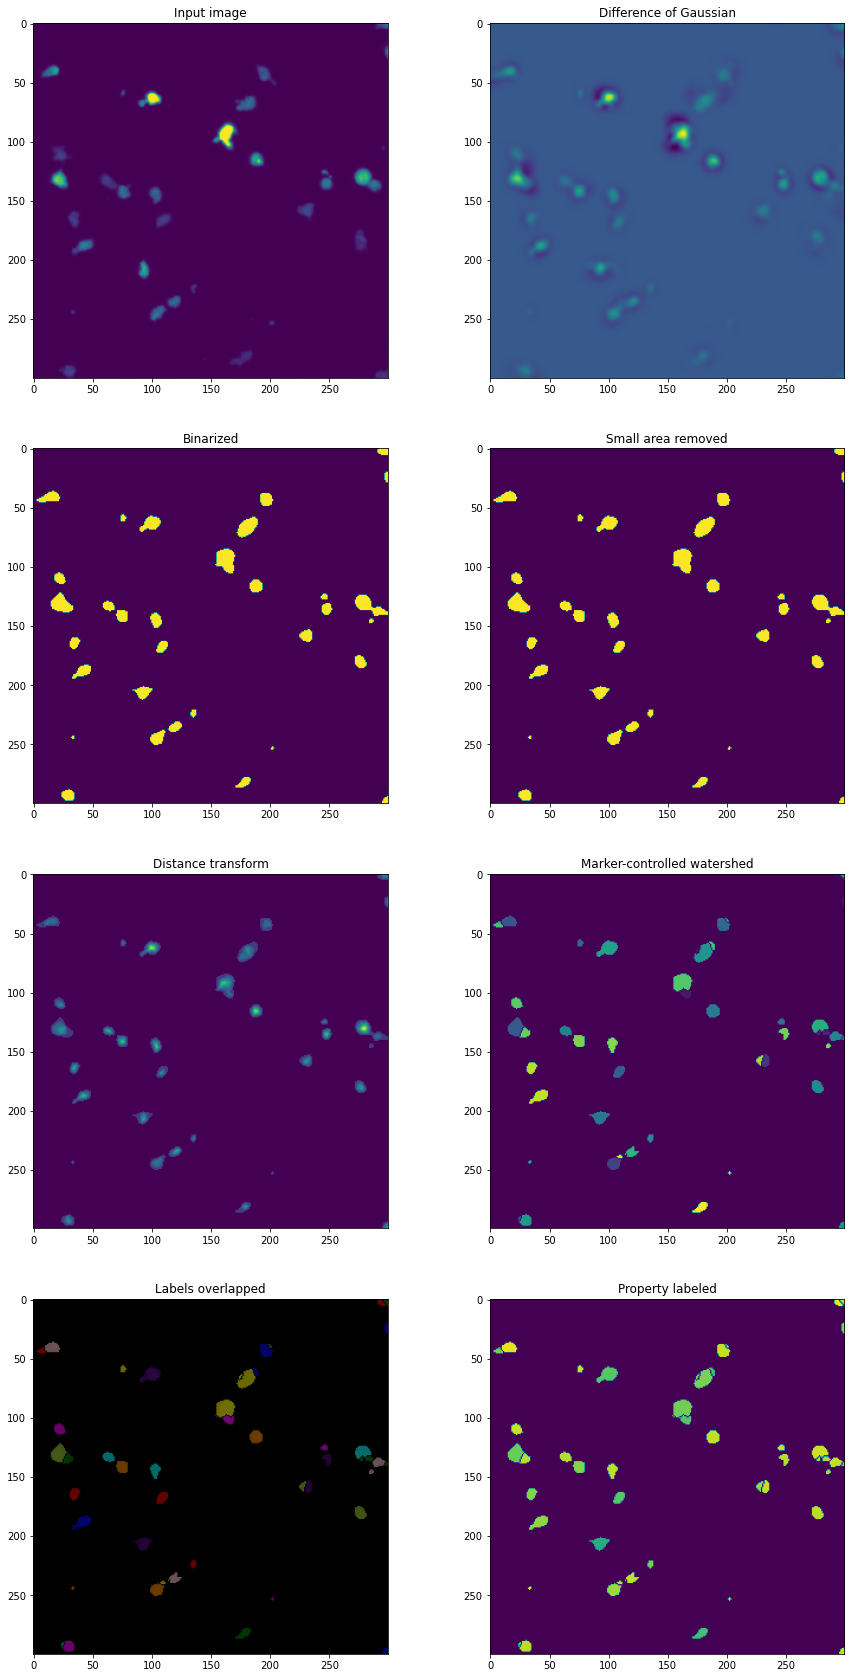

In [76]:
from tifffile import imread

img = imread('./Sample/image.tif')
# 2D画像にする場合
# img = img[0,:,:]

# セグメンテーション
dog, bw, large, dist, wat, color_labels, lab = segmentation_by_image_processing(img)

# 画像の表示
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 4, ncols=2, figsize=(15, 30))

if img.ndim==2:

    ax[0,0].imshow(img)
    ax[0,0].set_title('Input image')
    ax[0,1].imshow(dog)
    ax[0,1].set_title('Difference of Gaussian')
    ax[1,0].imshow(bw)
    ax[1,0].set_title('Binarized')
    ax[1,1].imshow(large)
    ax[1,1].set_title('Small area removed')
    ax[2,0].imshow(dist)
    ax[2,0].set_title('Distance transform')
    ax[2,1].imshow(wat)
    ax[2,1].set_title('Marker-controlled watershed')
    ax[3,0].imshow(color_labels)
    ax[3,0].set_title('Labels overlapped')
    ax[3,1].imshow(lab)
    ax[3,1].set_title('Property labeled')

    # chan-vese
    # ax[3,1].imshow(test, cmap="gray")

    # active contour
    # ax[3,1].plot(test2[:, 1], test2[:, 0], '-b', lw=3)
    
else:
    z = 5
    
    ax[0,0].imshow(img[z])
    ax[0,0].set_title('Input image')
    ax[0,1].imshow(dog[z])
    ax[0,1].set_title('Difference of Gaussian')
    ax[1,0].imshow(bw[z])
    ax[1,0].set_title('Binarized')
    ax[1,1].imshow(large[z])
    ax[1,1].set_title('Small area removed')
    ax[2,0].imshow(dist[z])
    ax[2,0].set_title('Distance transform')
    ax[2,1].imshow(wat[z])
    ax[2,1].set_title('Marker-controlled watershed')
    ax[3,0].imshow(color_labels[z])
    ax[3,0].set_title('Labels overlapped')
    ax[3,1].imshow(lab[z])
    ax[3,1].set_title('Property labeled')
